## Activation energy from NMR spectra
0. Imports

In [1]:
from kinetics.initial_rates import compInitialRate, compLeastSquaresRateLaw
from kinetics.json_definitions import readNMRIntegrationData

import os
import numpy
from matplotlib import pyplot as plt

1. Read the data from each NMR kinetic experiment JSON file.

In [2]:
path_to_kinetic_data = 'bromo_substrate/cod/kinetic_json'

experiments = {}

# Iterate over the kinetic experiment directories.
for file_name in [f for f in os.listdir(path_to_kinetic_data) if not f.startswith('.')]:
    path_to_file = os.path.join(path_to_kinetic_data, file_name)
    
    # Read kinetic experiment data.
    kinetic_experiment = readNMRIntegrationData(path_to_file)
    
    # Record time points, integrals and temperature in the experiments dictionary
    experiment_id = kinetic_experiment["experiment_id"]
    experiments[experiment_id] = {
        "time_points": kinetic_experiment["time_points"],
        "integrals": kinetic_experiment["integrals"],
        "temperature": kinetic_experiment["temperature"]
    }

2. Compute the initial rates by estimating the initial rate of change in the integral value of the monitored component.

In [3]:
experiments.keys()

dict_keys(['freecod_neg30', 'freecod_neg50', 'freecod_neg20', 'freecod_neg40'])

The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


There are not enough measurements within the percent of the reaction specified and the best approximation available is the slope of the chord obtained from the first concentration measurement.




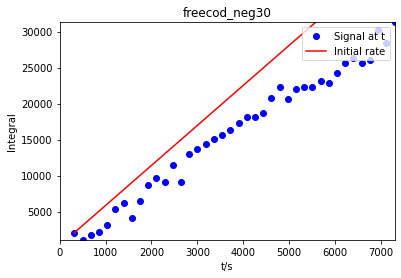

initial_rate =  5.55865168539326 signal/s
The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


There are not enough measurements within the percent of the reaction specified and the best approximation available is the slope of the chord obtained from the first concentration measurement.




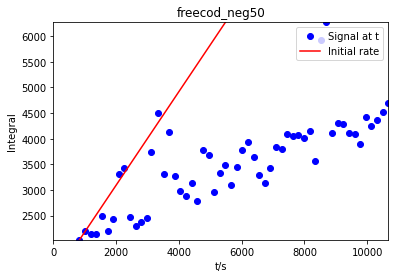

initial_rate =  0.9120670391061465 signal/s
The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


There are not enough measurements within the percent of the reaction specified and the best approximation available is the slope of the chord obtained from the first concentration measurement.




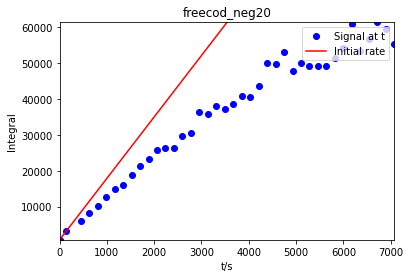

initial_rate =  17.147433566433566 signal/s
The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


There are not enough measurements within the percent of the reaction specified and the best approximation available is the slope of the chord obtained from the first concentration measurement.




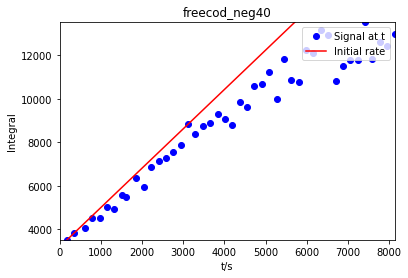

initial_rate =  1.8056172839506186 signal/s


In [4]:
# Add reaction information associated to each component ordered according to its position in the component id list.
component_ids = ['component_1']
component_is_reactant = [False]
stoichiometric_coefficients = [1.0]

# Set parameters used to compute the initial rate of change in concentration of each component in each experiment.
experiments['freecod_neg40']['initial_rate_parameters'] = {
    'component_1': {
        'time_range': slice(0,len(experiments['freecod_neg40']['time_points'])),
        'reaction_percentage': 100
    },
}

experiments['freecod_neg30']['initial_rate_parameters'] = {
    'component_1': {
        'time_range': slice(0,len(experiments['freecod_neg30']['time_points'])),
        'reaction_percentage': 100
    },
}

experiments['freecod_neg20']['initial_rate_parameters'] = {
    'component_1': {
        'time_range': slice(0,len(experiments['freecod_neg20']['time_points'])),
        'reaction_percentage': 100
    },
}
experiments['freecod_neg50']['initial_rate_parameters'] = {
    'component_1': {
        'time_range': slice(3,len(experiments['freecod_neg50']['time_points'])),
        'reaction_percentage': 100
    },
}    
#experiments['neg10_data']['initial_rate_parameters'] = {
 #   'component_1': {
  #      'time_range': slice(0,len(experiments['neg20_data']['time_points'])),
   #     'reaction_percentage': 30
    #},#
#}

experiment_ids = list(experiments.keys())
for experiment_id in experiment_ids:
    initial_rates = []
    for component_index, component_id in enumerate(component_ids):
        experiment = experiments[experiment_id]
        time_range = experiment['initial_rate_parameters'][component_id]['time_range']
        reaction_percentage = experiment['initial_rate_parameters'][component_id]['reaction_percentage']
        time_points_subset = experiment['time_points'][time_range]
        integrals_subset = experiment['integrals'][time_range]
        stoichiometric_coefficient = stoichiometric_coefficients[component_index]
        t = time_points_subset[:]
        time_points_subset = list(numpy.array(time_points_subset)-time_points_subset[0])

        initial_rate = compInitialRate(stoichiometric_coefficient, time_points_subset, integrals_subset, reaction_percentage)
        initial_rates.append(initial_rate)
        
        # Generate initial rate curve.
        is_reactant = component_is_reactant[component_index]
        initial_rate_curve = integrals_subset[0]  + numpy.multiply(
            (-1 if is_reactant else 1) * stoichiometric_coefficient * initial_rate,
            time_points_subset)

        # Plot kinetic data and the initial rate curve.
        plt.title(f"{experiment_id}") 
        plt.xlabel("t/s") 
        plt.ylabel(f"Integral") 
        plt.plot(t, integrals_subset, "-bo", linestyle='none', label = f"Signal at t")
        plt.plot(t, initial_rate_curve,  "-r", label = "Initial rate")
        plt.legend(loc = "upper right")
        plt.ylim(min(integrals_subset), max(integrals_subset))
        plt.xlim(0, t[-1])
        plt.show()
        print("initial_rate = ", initial_rate, "signal/s")
    experiments[experiment_id]['initial_rates'] = initial_rates

3. Compute the activation energy using linear regression.

Ea: 11.088736999692276 kcal/mol


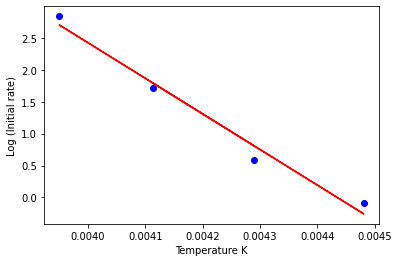

In [5]:
# R = 8.31446261815324 # J/(mol*K)
R = 1.98720425864083e-3 # kcal/(mol*K)
initial_rates = [
    experiments[experiment_id]['initial_rates'][0]
    for experiment_id in experiment_ids
]
temperatures = [
    experiments[experiment_id]['temperature']
    for experiment_id in experiment_ids
]
A = numpy.vstack((numpy.ones(len(temperatures)), numpy.reciprocal(numpy.multiply(-R,temperatures)).T)).T
b = numpy.log(initial_rates)
x = numpy.linalg.lstsq(A, b, rcond=None)[0]
Ea = x[1]
fit = [x[0]-Ea/(R*temperature) for temperature in temperatures]
print(f"Ea: {x[1]} kcal/mol")
plt.xlabel("Temperature K") 
plt.ylabel("Log (Initial rate)") 
plt.plot(numpy.reciprocal(temperatures), numpy.log(initial_rates), "-bo", linestyle='none')
plt.plot(numpy.reciprocal(temperatures), fit, "-r")
plt.show()

In [6]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = "arial"
rcParams.update({'font.size': 22})
rcParams['legend.loc'] = 'upper left'
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = numpy.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

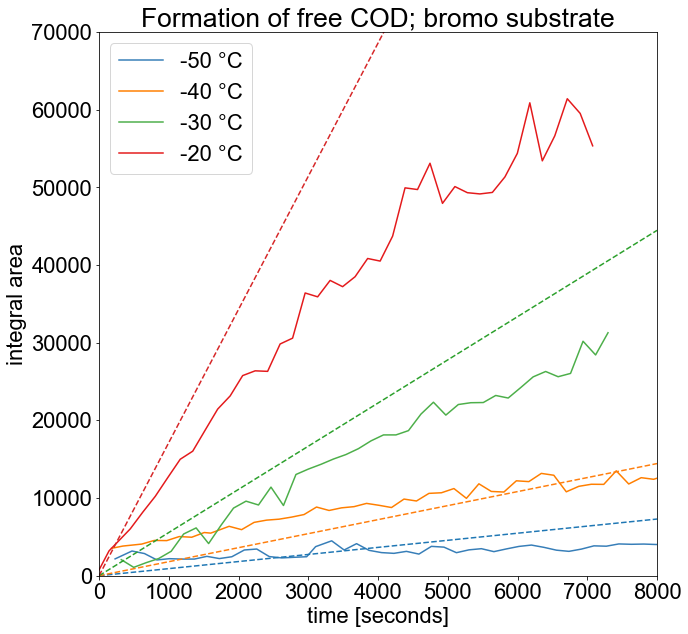

In [7]:
fig = plt.figure(figsize=(10, 10))
plt.plot(experiments['freecod_neg50']['time_points'],experiments['freecod_neg50']['integrals'], label = '-50 \u00B0C', color = '#377eb8')
plt.plot(experiments['freecod_neg40']['time_points'],experiments['freecod_neg40']['integrals'], label = '-40 \u00B0C', color = '#ff7f00')
plt.plot(experiments['freecod_neg30']['time_points'],experiments['freecod_neg30']['integrals'], label = '-30 \u00B0C', color = '#4daf4a')
plt.plot(experiments['freecod_neg20']['time_points'],experiments['freecod_neg20']['integrals'], label = '-20 \u00B0C', color = '#e41a1c')
plt.legend()
plt.xlabel('time [seconds]')
plt.ylabel('integral area')
plt.title('Formation of free COD; bromo substrate')

plt.xlim(0,8000)
plt.ylim(0,70000)
abline(0.912,0)
abline(1.805,0)
abline(5.559,0)
abline(17.147,0)
plt.savefig('/Users/zarko/Documents/zarkolab/projects/nickel_spiroindane/bromo_COD_formation_kinetics.svg')

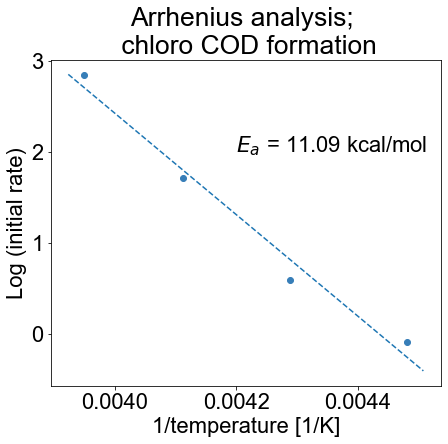

In [8]:
fig = plt.figure(figsize=(7, 6))
plt.plot(numpy.reciprocal(temperatures), numpy.log(initial_rates), marker = 'o', linestyle='none', color = '#377eb8')
plt.xlabel("1/temperature [1/K]") 
plt.ylabel("Log (initial rate)") 
plt.title('Arrhenius analysis; \n chloro COD formation')
plt.text(0.0042, 2,r'$E_a$ = 11.09 kcal/mol')
abline(-11.088737/1.98720425864083e-3,24.74674593)
plt.savefig('/Users/zarko/Documents/zarkolab/projects/nickel_spiroindane/arrhenius_br_cod.svg')